In [6]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import random as rn
import os
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import keras.utils
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras import layers
from keras import optimizers
from keras.applications import InceptionV3
import tensorflow as tf
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop



import datetime
import pandas as pd
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [7]:
print(os.listdir('data/img/train'))

['parabola', 'elipse']


In [8]:
X=[]
Z=[]
IMG_SIZE=(150,150)
elipse='data/img/train/elipse'
parabola='data/img/train/parabola'

In [9]:
def assign_label(img,curve_type):
    return curve_type

In [10]:
def make_train_data(curve_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,curve_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, IMG_SIZE)
        
        X.append(np.array(img))
        Z.append(str(label))

In [11]:
make_train_data('elipse',elipse)
print(len(X))

100%|██████████| 826/826 [00:51<00:00, 16.13it/s]

826


In [12]:
make_train_data('parabola',parabola)
print(len(X))

100%|██████████| 784/784 [01:02<00:00, 12.47it/s]

1610


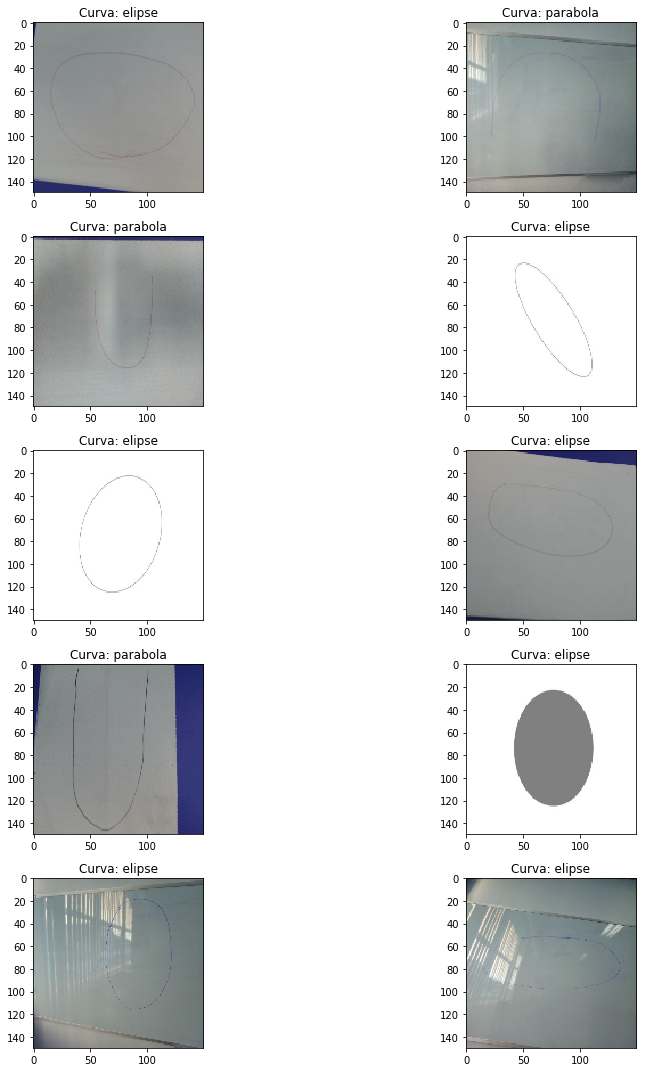

In [13]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Curva: '+Z[l])
        
plt.tight_layout()

In [14]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,2)
X=np.array(X)
X=X/255

In [15]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [16]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [17]:
# Generate a model with all layers (with top)
inceptionV3 = InceptionV3(weights=None, include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Create the model
model = models.Sequential()
 
# Add the vgg convolutional base model
model.add(inceptionV3)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))


In [18]:
batch_size=284
epochs=1000

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [20]:
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2050      
Total params: 40,680,226
Trainable params: 40,645,794
Non-trainable params: 34,432
_________________________________________________________________


In [22]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/1000
4/4 [==============================] - 28s 7s/step - loss: 1.9673 - acc: 0.5546 - val_loss: 2.2220 - val_acc: 0.6898
Epoch 2/1000
4/4 [==============================] - 3s 646ms/step - loss: 1.0317 - acc: 0.6005 - val_loss: 1.2912 - val_acc: 0.4963
Epoch 3/1000
4/4 [==============================] - 2s 467ms/step - loss: 0.7632 - acc: 0.5290 - val_loss: 1.8279 - val_acc: 0.7221
Epoch 4/1000
4/4 [==============================] - 2s 464ms/step - loss: 0.5715 - acc: 0.7036 - val_loss: 2.3059 - val_acc: 0.6849
Epoch 5/1000
4/4 [==============================] - 2s 527ms/step - loss: 0.6376 - acc: 0.6923 - val_loss: 2.0994 - val_acc: 0.6973
Epoch 6/1000
4/4 [==============================] - 2s 607ms/step - loss: 0.5299 - acc: 0.7394 - val_loss: 1.7130 - val_acc: 0.7022
Epoch 7/1000
4/4 [==============================] - 4s 925ms/step - loss: 0.5470 - acc: 0.7296 - val_loss: 1.6866 - val_acc: 0.5980
Epoch 8/1000
4/4 [==============================] - 4s 933ms/step - loss: 0.50

In [23]:
plt.figure(figsize=(20,12),dpi=96) #96 is my screen DPI
dataAtual = datetime.datetime.now()
dataHora = dataAtual.strftime("%H%M%d%m%y")
print(dataHora)

1503260319


<Figure size 1920x1152 with 0 Axes>

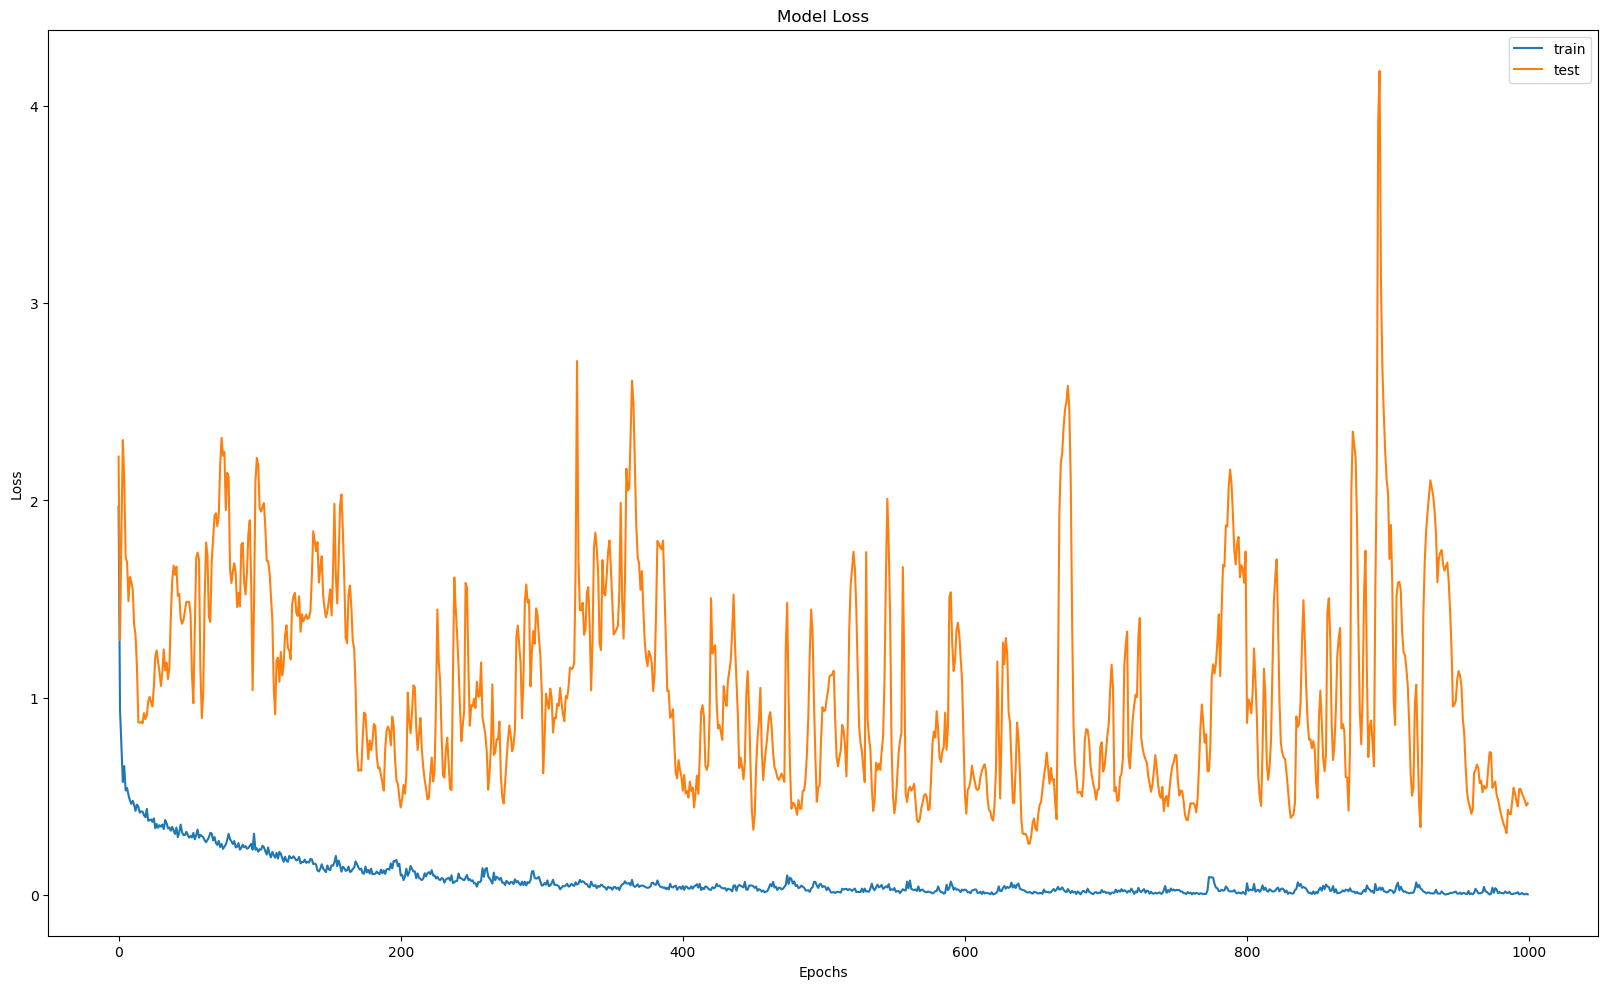

In [24]:
plt.figure(figsize=(20,12),dpi=100)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("InceptionV3"+dataHora+'Batch'+str(batch_size)+'Loss.png',type="png",dpi=300)
plt.show()

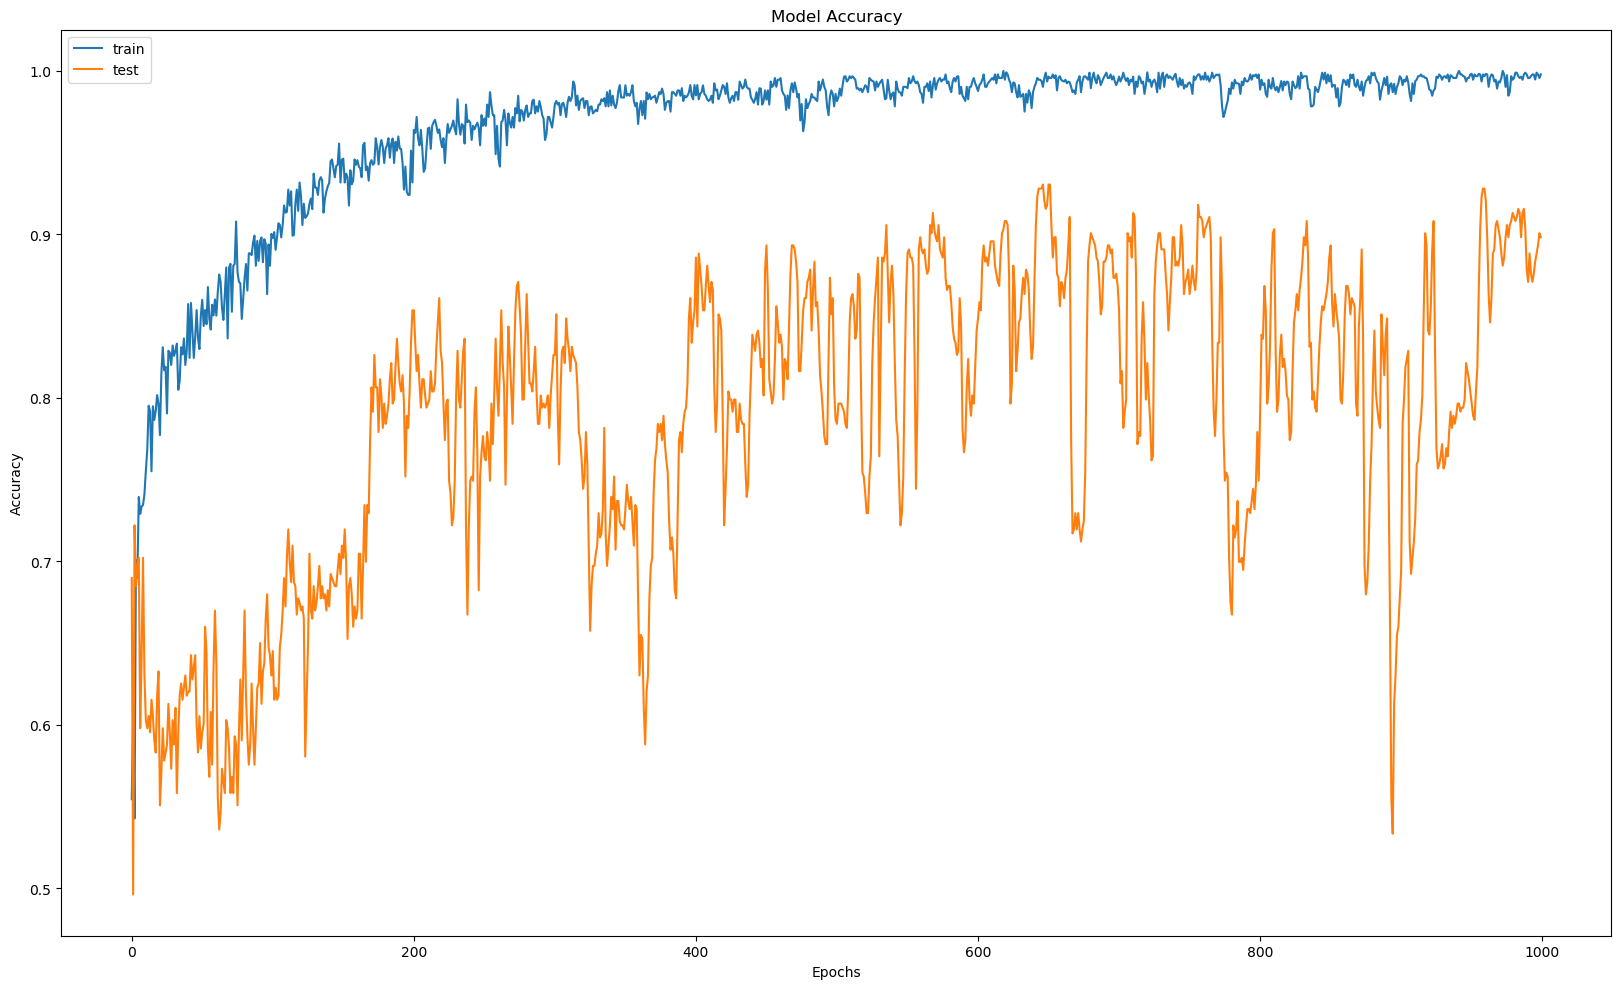

In [25]:
plt.figure(figsize=(20,12),dpi=100)
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("InceptionV3"+dataHora+'Batch'+str(batch_size)+'Epochs.png',type="png",dpi=300)
plt.show()

In [26]:
#keras.utils.plot_model(model, to_file=dataHora+'Batch'+str(batch_size)+'InceptionV3model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

In [27]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [28]:
model.save_weights("InceptionV3"+dataHora+'Batch'+str(batch_size)+'.weights')
model.save("InceptionV3"+dataHora+'Batch'+str(batch_size)+'.h5')

In [29]:
df = pd.read_csv("static.csv")
df.head()

,rede,epocas,maxLoss,maxValLoss,maxAcc,maxValAcc,minLoss,minValLoss,minAcc,minValAcc,meanLoss,meanValLoss,meanAcc,meanValAcc


In [30]:
rede = "InceptionV3"
#epochs
maxLoss = np.max(History.history['loss'])
maxValLoss = np.max(History.history['val_loss'])
maxAcc = np.max(History.history['acc'])
maxValAcc = np.max(History.history['val_acc'])

minLoss = np.min(History.history['loss'])
minValLoss = np.min(History.history['val_loss'])
minAcc = np.min(History.history['acc'])
minValAcc = np.min(History.history['val_acc'])

meanLoss = np.mean(History.history['loss'])
meanValLoss = np.mean(History.history['val_loss'])
meanAcc = np.mean(History.history['acc'])
meanValAcc = np.mean(History.history['val_acc'])


In [31]:
row = [rede,epochs,maxLoss, maxValLoss, maxAcc, maxValLoss,minLoss,minValLoss,minAcc,minValAcc,meanLoss,meanValLoss,meanAcc,meanValAcc]
df.loc[len(df)] = row
export_csv = df.to_csv("static.csv")
df.head()

,rede,epocas,maxLoss,maxValLoss,maxAcc,maxValAcc,minLoss,minValLoss,minAcc,minValAcc,meanLoss,meanValLoss,meanAcc,meanValAcc
0,InceptionV3,1000,1.967311,4.176482,1.0,4.176482,0.00274,0.260376,0.542795,0.496278,0.079813,1.050197,0.966133,0.788104
